# Car Depriciation model - Madhurima Biswas 

In [1]:
#Set Working Directory
import os
os.chdir("F:\DS\Projects\Car Dep model")
os.getcwd()

'F:\\DS\\Projects\\Car Dep model'

# Load Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from random import randrange, uniform
from scipy.stats import chi2_contingency
from ggplot import *
from fancyimpute import KNN
import seaborn as sns
import statsmodels.api as sm

C:\Users\sir\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\sir\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Load the data
data = pd.read_csv("cars.csv")

# Exploratory Data Analysis

In [4]:
data.shape

(2820, 16)

In [5]:
#data.head(10)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 16 columns):
MMV              2820 non-null object
Make             2820 non-null object
Model            2820 non-null object
Variant          2820 non-null object
Type             2820 non-null object
Transmission     2820 non-null object
Fuel Type        2820 non-null object
Age              2820 non-null int64
No of Owners     2820 non-null int64
Color            2820 non-null object
Health Score     2820 non-null float64
Price Score      2820 non-null float64
Distance         2820 non-null object
On Road Price    2820 non-null int64
Current Price    2820 non-null int64
Dep              2820 non-null float64
dtypes: float64(3), int64(4), object(9)
memory usage: 352.6+ KB


In [6]:
#Checking the unique values of each column
col = data.columns.values.tolist()
for col in data:
    print (col,":",data[col].nunique())
    #print (data[col].unique()) 

MMV : 473
Make : 4
Model : 58
Variant : 398
Type : 6
Transmission : 3
Fuel Type : 8
Age : 12
No of Owners : 6
Color : 34
Health Score : 56
Price Score : 64
Distance : 1128
On Road Price : 448
Current Price : 510
Dep : 690


In [7]:
'''
Column "Distance" is a numeric type variable, but it has commas ',' which we don't need.
Hence, we remove ',' from that column.
'''
data['Distance'] = data['Distance'].str.replace(',','')

In [8]:
#To change the variables to proper data types
#save numeric & categorical names
catnames = ["MMV","Make","Model","Variant","Type","Fuel Type","Transmission","Color","No of Owners"]
numnames = ["Age","Distance","Health Score","Price Score","On Road Price","Current Price"]
for i in catnames:
    data[i] = data[i].astype('object')
for i in numnames:
    data[i] = data[i].astype('float')
#data.dtypes

In [9]:
#Missing Value Analysis
#Check for missing value
data.isnull().sum()
#No missing values in the dataset

MMV              0
Make             0
Model            0
Variant          0
Type             0
Transmission     0
Fuel Type        0
Age              0
No of Owners     0
Color            0
Health Score     0
Price Score      0
Distance         0
On Road Price    0
Current Price    0
Dep              0
dtype: int64

# Exploratory Graphical Analysis

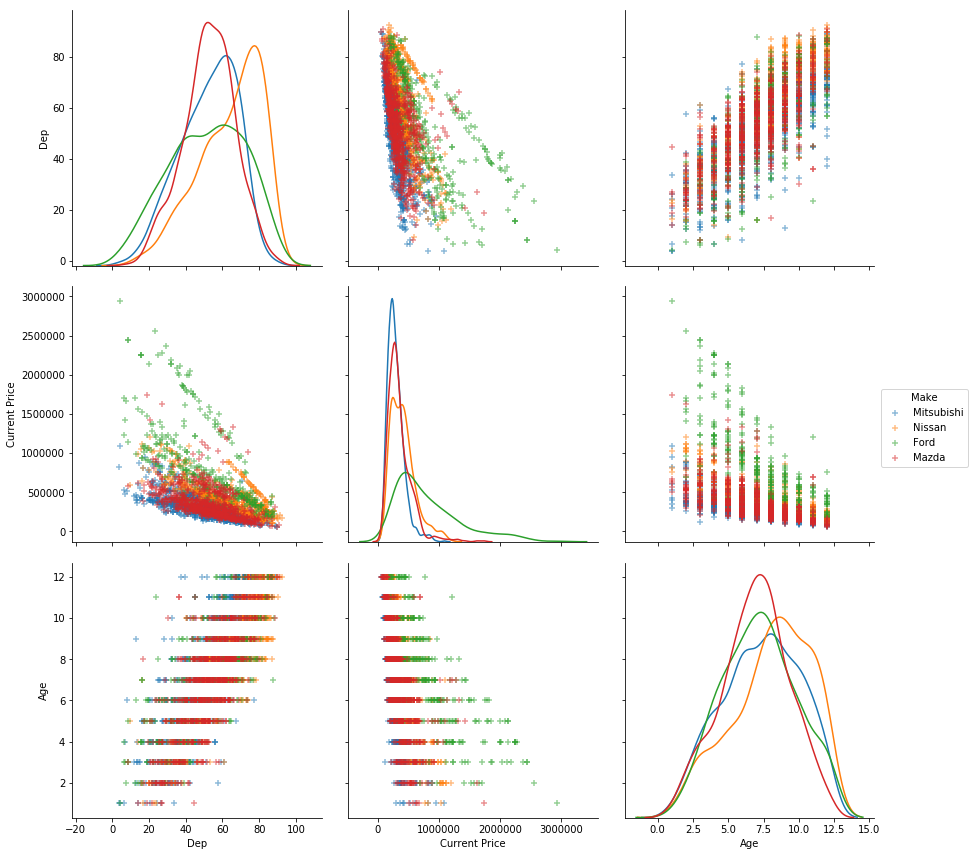

In [10]:
D = data[["Dep","Current Price","Age","Make"]]
sns.pairplot(D, hue = 'Make', diag_kind = 'kde', markers = '+',
             plot_kws = {'alpha': 0.5, 's': 30, 'edgecolor': 'k'},
             size = 4)

In [11]:
#Mitsubishi's prices are lower compared to other brands. 
#As age of the car increases, Depreciation rate also increases.

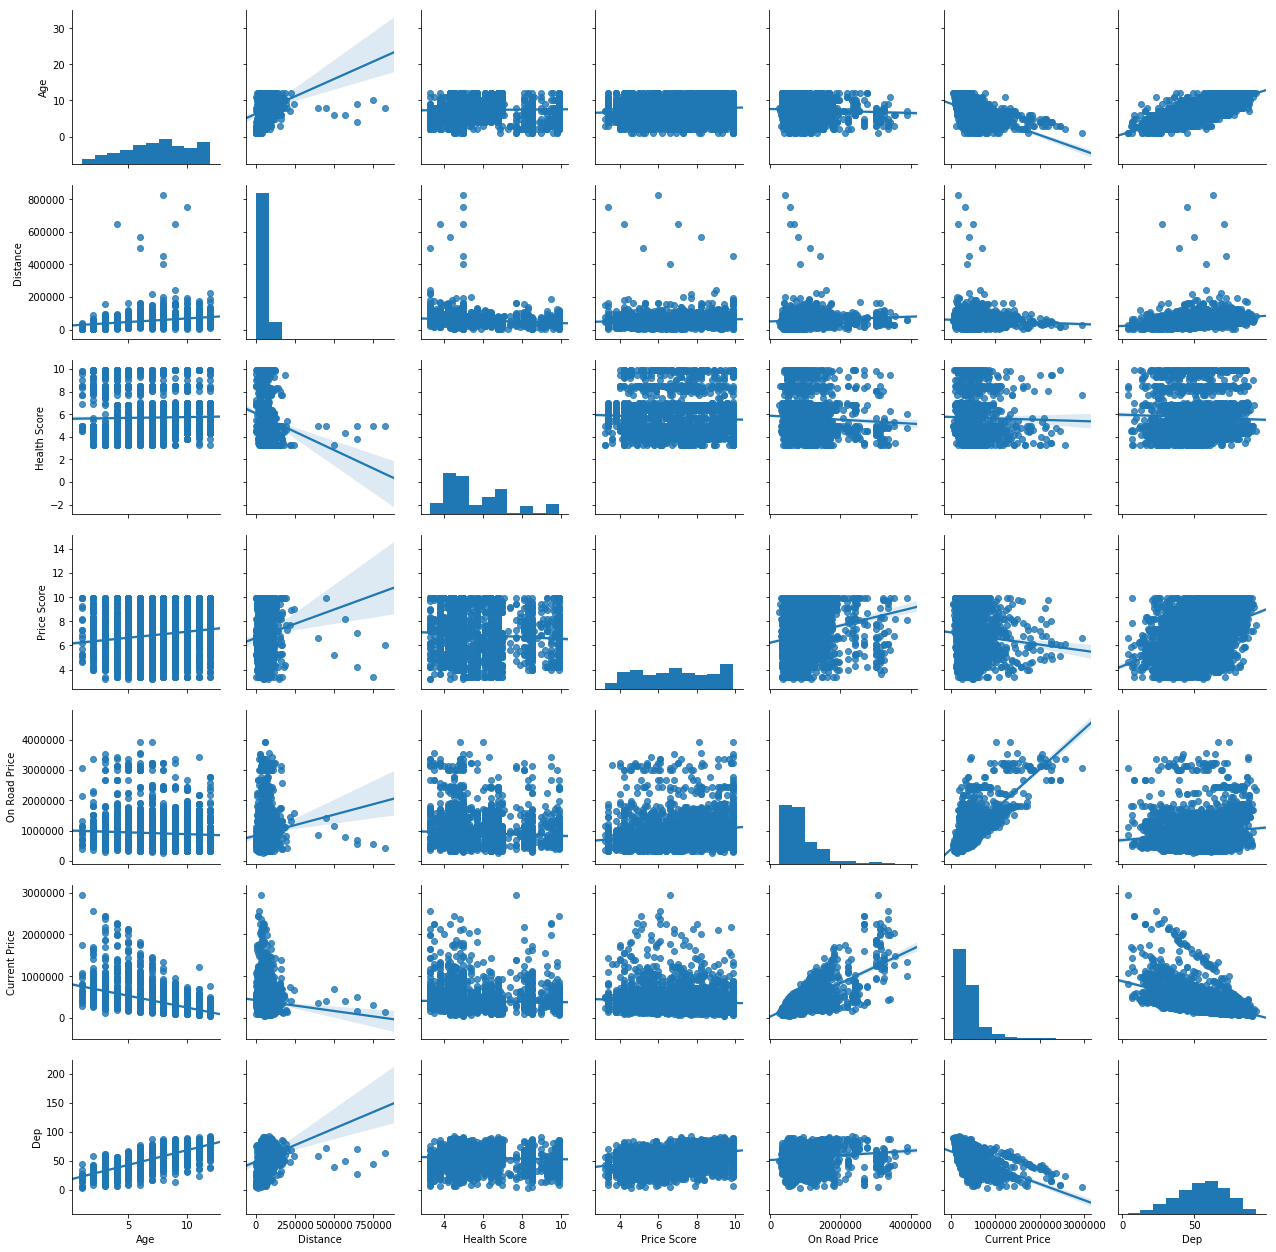

In [12]:
#Plotting Numerical Variables
D = data[["Age","Distance","Health Score","Price Score","On Road Price","Current Price","Dep"]]
sns.pairplot(D, kind = "reg")

# Outlier Analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x1ae57ccc6d8>,
 'caps': [<matplotlib.lines.Line2D at 0x1ae57e609e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ae57c73240>],
 'medians': [<matplotlib.lines.Line2D at 0x1ae57e41048>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ae57e41eb8>],
 'means': []}

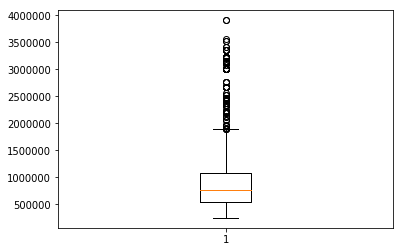

In [13]:
#Plot boxplot to visualize Outliers
%matplotlib inline  
plt.boxplot(data['On Road Price'])

In [14]:
#Detect and delete outliers from data
for i in numnames:
     #print(i)
     q75, q25 = np.percentile(data.loc[:,i], [75 ,25])
     iqr = q75 - q25

     min = q25 - (iqr*1.5)
     max = q75 + (iqr*1.5)
     #print(min)
     #print(max)
        
     #Remove the outliers
     data = data.drop(data[data.loc[:,i] < min].index)
     data = data.drop(data[data.loc[:,i] > max].index)        
     
data.shape          # 13.86% of data is removed, as 391 rows deleted.

(2429, 16)

# Feature Selection

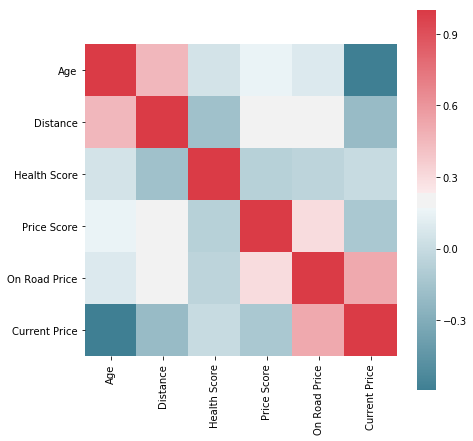

In [15]:
##Correlation analysis
#Correlation plot
df_corr = data.loc[:,numnames]
#Set the width and height of the plot
f, ax = plt.subplots(figsize=(7, 7))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

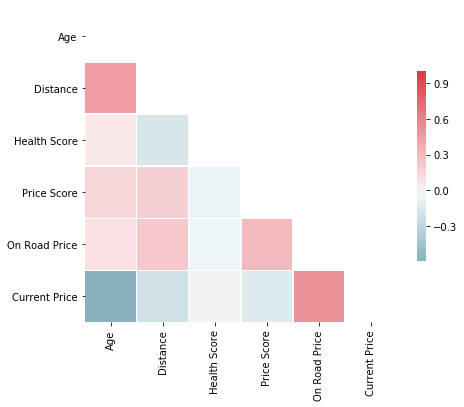

In [16]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#We observe, "Distance"-"Age", "Current Price"-"Age" (negatively), "On Road Price"-"Current Price" are relatively correlated.

In [17]:
#High Correlation Filter for Independent variables
#Note: The last variable "Dep" is our Output Variable and we don't apple a high correlation filter for that one.
#We can exclude one of variables which are highly correlated |r|>0.7.
data.corr()

#"Current Price"-"Age" & "Current Price"-"on road price" are relatively correlated. 

,Age,Health Score,Price Score,Distance,On Road Price,Current Price,Dep
Age,1.000000,0.052886,0.153296,0.457501,0.092124,-0.594758,0.785177
Health Score,0.052886,1.000000,-0.067988,-0.169284,-0.040890,-0.002803,-0.038937
Price Score,0.153296,-0.067988,1.000000,0.193944,0.298484,-0.124149,0.452541
Distance,0.457501,-0.169284,0.193944,1.000000,0.221885,-0.207425,0.481672
On Road Price,0.092124,-0.040890,0.298484,0.221885,1.000000,0.514747,0.354957
Current Price,-0.594758,-0.002803,-0.124149,-0.207425,0.514747,1.000000,-0.552134
Dep,0.785177,-0.038937,0.452541,0.481672,0.354957,-0.552134,1.000000


In [18]:
#Because the 'str' does not have numerical meaning for the classifier:
#we may get Error such as "ValueError: could not convert string to float"
#To encode all the data which are categorized to dtype:object
#data = pd.read_csv("cars_clean.csv")
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in data.columns:
    if data[i].dtype == object:
        data[i] = le.fit_transform(data[i])
    else:
        pass

In [19]:
#loop for chi square values of Independent variables wrt each other (within Categorical Variables)
for i in catnames:
    print ('\n')
    for j in catnames:
        if (i!=j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(data[i], data[j]))
            print(i, ' Vs ', j, ':')
            print('p-value =', p)

'''
If p-value<0.05 (Reject Null Hypothesis) => Variables are dependent. : Not important for prediction = Redundant (Associated).
If p-value>0.05 (Do Not Reject Null Hypothesis) => Variables are independent. 
'''
#'MMV','Make','Model','Variant' are the least favourable features acc. to this test.



MMV  Vs  Make :
p-value = 0.0
MMV  Vs  Model :
p-value = 0.0
MMV  Vs  Variant :
p-value = 0.0
MMV  Vs  Type :
p-value = 0.0
MMV  Vs  Fuel Type :
p-value = 0.0
MMV  Vs  Transmission :
p-value = 0.0
MMV  Vs  Color :
p-value = 1.4353628865047457e-110
MMV  Vs  No of Owners :
p-value = 0.9736871872102378


Make  Vs  MMV :
p-value = 0.0
Make  Vs  Model :
p-value = 0.0
Make  Vs  Variant :
p-value = 0.0
Make  Vs  Type :
p-value = 8.065407033558104e-260
Make  Vs  Fuel Type :
p-value = 4.1786571489192645e-51
Make  Vs  Transmission :
p-value = 5.938528301305281e-09
Make  Vs  Color :
p-value = 1.9376671082018443e-20
Make  Vs  No of Owners :
p-value = 0.004119010547295543


Model  Vs  MMV :
p-value = 0.0
Model  Vs  Make :
p-value = 0.0
Model  Vs  Variant :
p-value = 0.0
Model  Vs  Type :
p-value = 0.0
Model  Vs  Fuel Type :
p-value = 1.7933795221577096e-282
Model  Vs  Transmission :
p-value = 8.017453560566174e-235
Model  Vs  Color :
p-value = 2.1817368796251107e-163
Model  Vs  No of Owners :
p-v

'\nIf p-value<0.05 (Reject Null Hypothesis) => Variables are dependent. : Not important for prediction = Redundant (Associated).\nIf p-value>0.05 (Do Not Reject Null Hypothesis) => Variables are independent. \n'

In [20]:
#Low Variance filter for numerical variables
#We can drop the variables having low variance as variables with a low variance will not affect the target variable.

data.var()

#'Make', 'Transmission' & 'No of Owners' variables have relatively low Variance.

MMV              1.048283e+04
Make             7.038547e-01
Model            1.334389e+02
Variant          7.752509e+03
Type             2.247097e+00
Transmission     1.195915e-01
Fuel Type        1.847115e+00
Age              6.485619e+00
No of Owners     3.083306e-01
Color            4.711524e+01
Health Score     2.461460e+00
Price Score      3.666357e+00
Distance         4.508701e+08
On Road Price    1.053479e+11
Current Price    1.960594e+10
Dep              2.417838e+02
dtype: float64

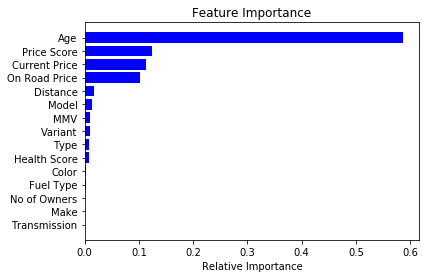

In [21]:
#Using Random forest's in-built feature importance
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
df=data
df = df.drop('Dep', axis=1)
model.fit(df,data.Dep)
#To plot the importance values:
features = data.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  #displays top 15 features
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#'Transmission',Make','No of Owner','Fuel Type' are the least important here.

In [22]:
#To check multicollinearity
#Define a function to calculate the VIF values

from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_cal(input_data, target):
    x_vars=input_data.drop([target], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y, x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)
        
#Calling VIF function
#vif_cal(input_data=data, target="Dep")

'''
MMV  VIF =  131.24
Make  VIF =  127.5
Model  VIF =  16.12
Variant  VIF =  7.66
Type  VIF =  6.37
Transmission  VIF =  24.54
Fuel Type  VIF =  6.35
Age  VIF =  24.99
No of Owners  VIF =  1.34
Color  VIF =  5.03
Health Score  VIF =  14.29
Price Score  VIF =  15.82
Distance  VIF =  10.27
On Road Price  VIF =  23.84
Current Price  VIF =  19.37
'''

#"MMV","Make" have very high multicollinearity.
#Let's check the VIF after removing these two variables.
#dt = data.drop(["Make","MMV"],axis=1)
#vif_cal(input_data=dt, target="Dep")

'''
Model  VIF =  8.2
Variant  VIF =  6.68
Type  VIF =  5.61
Transmission  VIF =  23.2
Fuel Type  VIF =  6.34
Age  VIF =  23.3
No of Owners  VIF =  1.34
Color  VIF =  5.01
Health Score  VIF =  13.81
Price Score  VIF =  14.64
Distance  VIF =  10.18
On Road Price  VIF =  23.6
Current Price  VIF =  18.93
'''

#"on road price" has high multicollinearity. Let's redo VIF after removing it.
#dt = data.drop(["Make","MMV","On Road Price"],axis=1)
#vif_cal(input_data=dt, target="Dep")

#"Transmission" & "Age" has high multicollinearity. Let's redo VIF after removing it.
dt = data.drop(["Make","MMV","On Road Price","Transmission","Age"],axis=1)
vif_cal(input_data=dt, target="Dep")

#'Age' has high multicollinearity, but it also had high feature importance.

Model  VIF =  7.57
Variant  VIF =  5.36
Type  VIF =  4.64
Fuel Type  VIF =  6.01
No of Owners  VIF =  1.32
Color  VIF =  4.97
Health Score  VIF =  11.0
Price Score  VIF =  11.52
Distance  VIF =  7.64
Current Price  VIF =  7.29


In [23]:
#We drop "No of owner", "on road price" & "Transmission" based on previous tests.
#We drop "MMV" as well, because other variables 'Make', "Model" and 'Variant' have the same info & it's like an ID for the car.
data = data.drop(["Make","No of Owners","Variant","MMV","On Road Price", "Transmission"],axis=1)

#Update numnames & catnames:
numnames.remove("On Road Price")
catnames.remove("Make")
catnames.remove("No of Owners")
catnames.remove("Variant")
catnames.remove("MMV")
catnames.remove("Transmission")

In [24]:
#data.head(10)
data.shape
#We have total 10 variables now. (9 -> Independent)

(2429, 10)

# Feature Scaling

(array([  4.,   3.,  10.,   7.,  25.,  31.,  48.,  57.,  78.,  92., 119.,
        130., 137., 192., 179., 183., 208., 185., 164., 158., 121., 103.,
         72.,  66.,  47.,  10.]),
 array([ 6.7       ,  9.93076923, 13.16153846, 16.39230769, 19.62307692,
        22.85384615, 26.08461538, 29.31538462, 32.54615385, 35.77692308,
        39.00769231, 42.23846154, 45.46923077, 48.7       , 51.93076923,
        55.16153846, 58.39230769, 61.62307692, 64.85384615, 68.08461538,
        71.31538462, 74.54615385, 77.77692308, 81.00769231, 84.23846154,
        87.46923077, 90.7       ]),
 <a list of 26 Patch objects>)

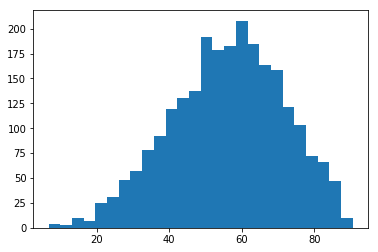

In [25]:
#Normality check
%matplotlib inline  
plt.hist(data['Dep'], bins='auto')

#Although the distribution is close to Normal curve, but this could be because of the outliers removed. 
#Future data might not be of such distribution or if we impute the outliers instead of removal.
#We go for normalization method.

In [26]:
#Nomalisation
#Only for numeric variables
for i in numnames:
    #print(i)
    data[i] = (data[i] - data[i].min())/(data[i].max() - data[i].min())

In [27]:
#data.head(10)
print(data.shape)
#12 <- Independent variables.
#Save the cleaned data
#data.to_csv("cars_clean.csv", index=False)

(2429, 10)


# Model Selection

In [28]:
#Data Sampling
#Splitting data into train (80%) & test (20%) datasets
nrow = len(data.index)
train, test = train_test_split(data, test_size = 0.2)
#train.shape     #1943 x 10
#test.shape       #486 x 10

In [29]:
#Making a dataframe just to store and compare each Algorithm's results
results=pd.DataFrame({'Algorithm':["Decision Tree","Random Forest","Linear Regression","KNN"], 
                      'RMSE_value':[0.0,0.0,0.0,0.0]})

In [30]:
#####1.Decision Tree Algortithm#####
#To fit DT on train set
from sklearn.tree import DecisionTreeRegressor
fit_dt= DecisionTreeRegressor(max_depth=2).fit(train.iloc[:,0:9],train.iloc[:,9])
fit_dt

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [31]:
#To predict on test set
predict_dt= fit_dt.predict(test.iloc[:,0:9])

In [32]:
#Calculate RMSE
def RMSE(actual, pred):
    return np.sqrt(((pred - actual) ** 2).mean())

results.loc[0,'RMSE_value'] = RMSE(test.iloc[:,9],predict_dt)  #RMSE error for Decision Tree

In [33]:
######2.Random Forest Algorithm#####
#To fit RF on train set
from sklearn.ensemble import RandomForestRegressor
fit_rf = RandomForestRegressor(n_estimators = 100, random_state = 99).fit(train.iloc[:,0:9],train.iloc[:,9])
fit_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=99, verbose=0, warm_start=False)

In [34]:
#To predict on test set
predict_rf= fit_rf.predict(test.iloc[:,0:9])

In [35]:
results.loc[1,'RMSE_value'] = RMSE(test.iloc[:,9],predict_rf) #RMSE error for Random Forest Algorithm

In [36]:
#####3.Multiple Linear Regression#####
#Creat dataframe with all numerical variables
df_lr = data[['Dep','Age', 'Distance', 'Health Score', 'Price Score', 'Current Price']] 
#NOTE: Output Variable "Dep" is now the first column (position '0') here.
#create dummies for categorical variables
for i in catnames:
    temp = pd.get_dummies(data[i],prefix = i)
    df_lr = df_lr.join(temp)

In [37]:
df_lr.shape

(2429, 95)

In [38]:
#We have 95 variables now.

#We should try to reduce the dimensionality
#Convert to numpy arrays
X = df_lr.iloc[:, 1:94].values
y = df_lr.iloc[:, 0].values

# Split into the Training set and Test set
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

C:\Users\sir\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
#X.shape                #2429 x 93
#y.shape                #2429 x 1
#Xtrain.shape           #1943 x 93
#Xtest.shape            #486  x 93
#ytrain.shape           #1943 x 1
#ytest.shape            #486 x 1

#We have 108 independent variables now.

In [40]:
#Using PCA to reduce dimensionality - independent variables
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#Scaling the values
sc = MinMaxScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

In [41]:
#To choose no. of components in PCA
from sklearn.preprocessing import scale
X = scale(X)
pca = PCA(n_components=93) 
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=93, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
var

array([3.74102151e-02, 3.15528299e-02, 2.73156351e-02, 2.49874198e-02,
       2.28562793e-02, 1.90978781e-02, 1.74867788e-02, 1.63188393e-02,
       1.59997277e-02, 1.51217748e-02, 1.48625856e-02, 1.44228036e-02,
       1.42326241e-02, 1.38983814e-02, 1.37552344e-02, 1.36444700e-02,
       1.35505348e-02, 1.32983143e-02, 1.29788265e-02, 1.28592858e-02,
       1.27357140e-02, 1.26712536e-02, 1.23194027e-02, 1.22977327e-02,
       1.21207597e-02, 1.19176706e-02, 1.17562535e-02, 1.16463778e-02,
       1.16114050e-02, 1.15544501e-02, 1.13691829e-02, 1.13123804e-02,
       1.12913185e-02, 1.11915059e-02, 1.11082291e-02, 1.10428516e-02,
       1.10063684e-02, 1.09797859e-02, 1.09189018e-02, 1.08669477e-02,
       1.08341404e-02, 1.08222410e-02, 1.08159570e-02, 1.07922481e-02,
       1.07784143e-02, 1.07741990e-02, 1.07705968e-02, 1.07638972e-02,
       1.07608721e-02, 1.07582855e-02, 1.06729196e-02, 1.06664685e-02,
       1.05966627e-02, 1.05559381e-02, 1.05082684e-02, 1.04507407e-02,
      

In [43]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var1

array([  3.74,   6.9 ,   9.63,  12.13,  14.42,  16.33,  18.08,  19.71,
        21.31,  22.82,  24.31,  25.75,  27.17,  28.56,  29.94,  31.3 ,
        32.66,  33.99,  35.29,  36.58,  37.85,  39.12,  40.35,  41.58,
        42.79,  43.98,  45.16,  46.32,  47.48,  48.64,  49.78,  50.91,
        52.04,  53.16,  54.27,  55.37,  56.47,  57.57,  58.66,  59.75,
        60.83,  61.91,  62.99,  64.07,  65.15,  66.23,  67.31,  68.39,
        69.47,  70.55,  71.62,  72.69,  73.75,  74.81,  75.86,  76.91,
        77.95,  78.98,  80.01,  81.03,  82.04,  83.04,  84.03,  85.  ,
        85.96,  86.9 ,  87.83,  88.75,  89.66,  90.55,  91.4 ,  92.23,
        93.04,  93.82,  94.59,  95.35,  96.05,  96.69,  97.3 ,  97.88,
        98.44,  98.91,  99.34,  99.7 ,  99.86,  99.95, 100.02, 100.06,
       100.06, 100.06, 100.06, 100.06, 100.06])

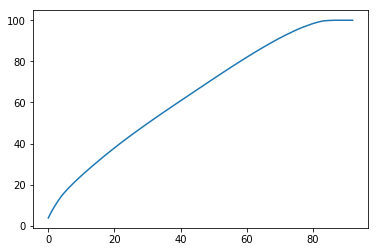

In [44]:
plt.plot(var1)

In [45]:
#Looking at above plot, selecting 82 components can preserve 99.34% of the total variance in data.

In [46]:
#Build MLR model (With PCA analysis)
pca = PCA(n_components = 82)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)
explained_variance = pca.explained_variance_ratio_

In [47]:
#Train regressor
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
#predict for test set
predict_lr = regr.predict(Xtest)
Rsq_lr = regr.score(Xtrain,ytrain)*100 
print(Rsq_lr)
#R-squared = 89.12%
#Approx. 89% of the variation in Depreciation rate% is explained by all the independent variables.

89.58252440889487


In [49]:
predict_lr

array([66.42793182, 42.5573152 , 62.65437933, 65.60442887, 64.8531598 ,
       44.88002181, 50.98561223, 29.63351529, 67.79763845, 56.68984688,
       55.95165624, 62.02624045, 51.22730484, 62.37959517, 64.94736307,
       49.08637706, 60.81183395, 40.8536289 , 52.08390618, 53.8190211 ,
       74.10845698, 49.86791798, 52.07057562, 44.8206194 , 68.40803452,
       56.19798522, 60.2835308 , 49.48387415, 33.39671796, 68.84784737,
       52.88183446, 48.26796511, 81.62770705, 77.94033238, 51.90492016,
       57.13445868, 60.64834043, 41.04276261, 40.44106708, 53.31849552,
       54.84390421, 48.80954467, 89.43498233, 52.12550425, 58.32999282,
       51.09778005, 59.6894955 , 67.57139723, 60.42827231, 77.08733233,
       48.75428788, 67.2659448 , 72.78297041, 70.90383797, 49.7163556 ,
       56.58511572, 63.88874265, 50.72106707, 61.34423378, 67.1416988 ,
       60.19184941, 67.41225191, 56.05090851, 48.23920147, 78.26807951,
       59.25405873, 41.995296  , 23.95816106, 48.21418418, 50.30

In [50]:
#Calculate RMSE for MLR
results.loc[2,'RMSE_value'] = RMSE(ytest,predict_lr) 

In [51]:
######4.KNN Implementation#####
#To find the optimum no. of k-neighbors 
from sklearn import neighbors
rmse_val = []           #to store rmse values for different k
for K in range(30):
    K = K+1
    fit_knn = neighbors.KNeighborsRegressor(n_neighbors = K)
    
    fit_knn.fit(train.iloc[:,0:9], train.iloc[:,9]) #fit the model
    
    predict_knn = fit_knn.predict(test.iloc[:,0:9]) #make prediction on test set
    error = RMSE(test.iloc[:,9] , predict_knn) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 11.153251569660375
RMSE value for k=  2 is: 10.703598535302893
RMSE value for k=  3 is: 10.461502793337868
RMSE value for k=  4 is: 10.24520928393388
RMSE value for k=  5 is: 10.278038395094114
RMSE value for k=  6 is: 10.524313332699125
RMSE value for k=  7 is: 10.826334677524088
RMSE value for k=  8 is: 11.03296342007458
RMSE value for k=  9 is: 11.206334101539445
RMSE value for k=  10 is: 11.519038722324876
RMSE value for k=  11 is: 11.784640198915543
RMSE value for k=  12 is: 11.996732546506557
RMSE value for k=  13 is: 12.122633184369034
RMSE value for k=  14 is: 12.221470708875344
RMSE value for k=  15 is: 12.363980034205687
RMSE value for k=  16 is: 12.52249374017559
RMSE value for k=  17 is: 12.713882778245173
RMSE value for k=  18 is: 12.859580386913121
RMSE value for k=  19 is: 12.93410101306262
RMSE value for k=  20 is: 13.008329341352274
RMSE value for k=  21 is: 13.083646686083835
RMSE value for k=  22 is: 13.13591593120292
RMSE value for k=  23 is

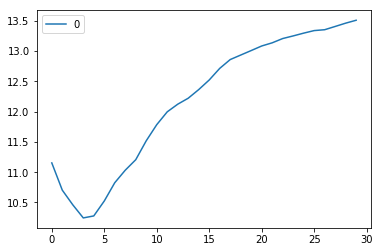

In [52]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)  
curve.plot()
#K=3 is the value of neighbors for least RMSE.

In [53]:
#For K=3:
fit_knn = neighbors.KNeighborsRegressor(n_neighbors = 3)
fit_knn.fit(train.iloc[:,0:9], train.iloc[:,9]) #fit the model
predict_knn = fit_knn.predict(test.iloc[:,0:9]) #make prediction on test set
results.loc[3,'RMSE_value'] = RMSE(test.iloc[:,9] , predict_knn) #RMSE error for KNN

In [54]:
#Comparing the RMSE errors of all algorithms:
results

,Algorithm,RMSE_value
0,Decision Tree,10.356044
1,Random Forest,5.785979
2,Linear Regression,5.158987
3,KNN,10.461503


In [55]:
'''
After comparing the errors or RMSE for each algorithm, we find Multivariate Linear Regression to be most appropriate as it gives the least error.
Also, linear Models have fewer parametersRa compared to Random Forests and so Random Forests might overfit more easily than a Linear Regression model.
-> Hence, We can choose "Multivariate Linear Regression" for modelling this dataset.
'''

'\nAfter comparing the errors or RMSE for each algorithm, we find Multivariate Linear Regression to be most appropriate as it gives the least error.\nAlso, linear Models have fewer parametersRa compared to Random Forests and so Random Forests might overfit more easily than a Linear Regression model.\n-> Hence, We can choose "Multivariate Linear Regression" for modelling this dataset.\n'